In [18]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from scipy.stats.mstats import mode

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures
from collections import defaultdict

import time
import datetime
from datetime import date, datetime, timedelta

import itertools

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

import os

### 1 import the data

1.1 Select users randomly

In [19]:
# random sample
num_users = 100000

# Extract the size of the input Dataframe
data= pd.read_csv('data.txt', delimiter='\t', chunksize=1000000)
user_id=[]

for chunk in data:
    col=chunk.columns
    user_id.extend(chunk.user_id)
    
# select unique users into a np array and print # of unique
users = np.unique(user_id)
print('total # unique user_id',users.shape[0])

# List of randomly selected unique users
np.random.RandomState(0)
random_users = np.random.choice(users, replace=False, size=num_users) 

total # unique user_id 805492


1.2 Extract data for selected users

In [20]:
data= pd.read_csv('data.txt', delimiter='\t', chunksize=1000000)
data_sample=pd.DataFrame(columns=col)
icount=0
for chunk in data:
    data_sample=pd.concat([data_sample,chunk[chunk['user_id'].isin(random_users)]], axis=0)
    icount+=1
    print(icount)
print('sample # unique user_id',data_sample.user_id.nunique())

1
2
3
4
5
6
7
8
9
10
11
sample # unique user_id 100000


### 2 scope, clean the data, create features and target variable

In [21]:
###### select scope of analysis 

# user location country
def scope(country='USA'): # function to define scope of analysis: USA, CAN, DE
    scope=''
    if country=='USA':
        scope="UNITED STATES OF AMERICA"
    elif country=='CAN':
        scope="CANADA"
    elif country=='DE':
        scope="GERMANY"
    else:
        print("Enter USA, CAN, or DE")
    return scope;

ds=data_sample
ds=ds[ds['user_location_country']==scope()]
print('sample # unique user_id',ds.user_id.nunique()) 

# site 
ds = ds[ds['site_name'] == 'EXPEDIA.COM']

# data cleaning 
ds = ds[ds['user_location_region']!='AOL']
ds = ds[ds['user_location_region']!='?']
#ds.duplicated(keep=False) there are none

sample # unique user_id 78570


In [22]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 992911 entries, 11 to 10884536
Data columns (total 27 columns):
date_time                    992911 non-null object
site_name                    992911 non-null object
user_location_country        992911 non-null object
user_location_region         992911 non-null object
user_location_city           992911 non-null object
user_location_latitude       871113 non-null float64
user_location_longitude      871113 non-null float64
orig_destination_distance    871113 non-null float64
user_id                      992911 non-null object
is_mobile                    992911 non-null object
is_package                   992911 non-null object
channel                      992911 non-null object
srch_ci                      992428 non-null object
srch_co                      992430 non-null object
srch_adults_cnt              992911 non-null object
srch_children_cnt            992911 non-null object
srch_rm_cnt                  992911 non-null object

191

In [67]:
ds['day_ss_year']=ds['date_ss'].timetuple().tm_yday
ds['day_ss_year']

AttributeError: 'Series' object has no attribute 'timetuple'

In [23]:
##### parse dates 
pd.options.mode.chained_assignment = None  # default='warn'

ds['date_ss']=pd.to_datetime(ds['date_time'],errors='coerce')
ds['date_ci']=pd.to_datetime(ds['srch_ci'],errors='coerce')  
ds['date_co']=pd.to_datetime(ds['srch_co'],errors='coerce')  

ds['month_ss'] = ds['date_ss'].dt.month  
ds['day_ss'] = ds['date_ss'].dt.dayofweek
ds['hour_ss'] = ds['date_ss'].dt.hour

ds['month_ci'] = ds['date_ci'].dt.month
ds['day_ci'] = ds['date_ci'].dt.dayofweek
#ds['hour_ci'] = ds['date_ci'].dt.hour

ds['month_co'] = ds['date_co'].dt.month 
ds['day_co'] = ds['date_co'].dt.dayofweek 
#ds['hour_co'] = ds['date_co'].dt.hour

calendar_dic={1.0:'January',2.0:'February',3.0:'March',4.0:'April',5.0:'May',6.0:'June',7.0:'July', 8.0:'August'\
          ,9.0:'September',10.0:'October',11.0:'November',12.0:'December'}

calendar_dic1={1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July', 8:'August'\
          ,9:'September',10:'October',11:'November',12:'December'}

#get month values from calendar
ds['date_ss1']=ds['month_ss'].map(calendar_dic1)
ds['month_ci1']=ds['month_ci'].map(calendar_dic)
ds['month_co1']=ds['month_co'].map(calendar_dic)


# create season (categorical)
def seas(x):
    if x==12.0 or x==1.0 or x==2.0:
        season='is_winter'
    elif x==3.0 or x==4.0 or x==5.0:
        season='is_spring'
    elif x==6.0 or x==7.0 or x==8.0:
        season="is_summer"
    else: 
        season="is_autumn"
    return season;

ds['season_cat'] = ds['month_ci'].apply(lambda row: seas(row))

# create Length Of Stay (LOS) and converts it to float
ds['LOS']=ds['date_co']-ds['date_ci']  
try:
    ds['LOS']=np.round(ds['LOS'] / np.timedelta64(1, "D"),decimals=1)
except:
    pass

# Create bins for LOS based on quantile distribution (except 1 day)
bin_ranges_LOS = [0, 1, 2, 4, 375]
bin_names_LOS = ['0to1day', '1to2days', '2to4days', 'over4days']

ds['LOS_range'] = pd.cut(np.array(
                           ds['LOS']), 
                           bins=bin_ranges_LOS)
                    
ds['LOS_cat'] = pd.cut(np.array(
                         ds['LOS']),
                         bins=bin_ranges_LOS,            
                         labels=bin_names_LOS)


#dayslist_bk==dateslist_bk to days, unique 
#dates_va =dates_fd+dates_sc from CSV tbd [ext]
#is_vacation==bool based on bk_dateslist in dates_va - Might not be needed

# identify is date search is saturday or sunday 
ds['is_satsun_ss']=0
ds.loc[(ds['day_ss']==6) | (ds['day_ss']==7),'is_satsun_ss']=1 

# identify if hours search are business hours [8am-7pm]
ds['is_worktime_ss']=0
ds.loc[(ds['hour_ss']>=8) & (ds['hour_ss']<=19),'is_worktime_ss']=1

# identify if dates travel include w-e days (is_satsun=1) or week days (is_monfri=1)
ds['is_satsun']=1  # initialize
ds.loc[(ds['LOS']==0) & (ds['day_ci']<=5),'is_satsun']=0    
ds.loc[(ds['LOS']==1) & (ds['day_ci']<=4),'is_satsun']=0   
ds.loc[(ds['LOS']==2) & (ds['day_ci']<=3),'is_satsun']=0
ds.loc[(ds['LOS']==3) & (ds['day_ci']<=2),'is_satsun']=0
ds.loc[(ds['LOS']==4) & (ds['day_ci']<=1),'is_satsun']=0

ds['is_monfri']=1  # initialize
ds.loc[(ds['LOS']==0) & (ds['day_ci']>5), 'is_monfri']=0
ds.loc[(ds['LOS']==1) & (ds['day_ci']==6),'is_monfri']=0

# create Booking Window session (BW_ss) and converts it to float
ds['BW_ss']=ds['date_ci']-ds['date_ss']  # should be >0
try:
    ds['BW_ss']=np.round(ds['BW_ss'] / np.timedelta64(1, "D"),decimals=1) 
except:
    pass

# Create bins for BW ~based on quantile distribution (except 1 day)
bin_ranges_BW = [0, 1, 7, 30, 60, 560]
bin_names_BW = ['0to1day', '1to7days', '7to30days', '30to60days','over60days']

ds['BW_ss_range'] = pd.cut(np.array(
                           ds['BW_ss']), 
                           bins=bin_ranges_BW)
                    
ds['BW_ss_cat'] = pd.cut(np.array(
                         ds['BW_ss']),
                         bins=bin_ranges_BW,            
                         labels=bin_names_BW)


# Data cleaning : subsetting of DataFrame (realistic ranges, xpdia.com)
ds = ds[ds['BW_ss'] >= 0]
ds['BW_ss_cat']=ds['BW_ss_cat'].fillna('0to1day')  # issue with NAN in case 'BW_ss' is ~-0 day
#ds['BW_ss_range']=ds['BW_ss_range'].fillna('(0,1]') # same 
ds = ds[ds['LOS'] >= 0]
ds = ds[ds['srch_adults_cnt'] !=0]
ds['LOS_cat']=ds['LOS_cat'].fillna('0to1day')  # issue with NAN in case 'BW_ss' is ~-0 day
#ds['LOS_range']=ds['LOS_range'].fillna('(0,1]')# same 

print('sample # unique user_id',ds.user_id.nunique()) 


##### not put here: day of the year. To add for improvement.


#day_of_year = datetime.now().timetuple().tm_yday
3day_of_year 



##### useful code to parse date. not used here.
#props = {}
#for prop in ["month", "day", "hour", "minute", "dayofweek", "quarter"]:
#    props[prop] = getattr(ds1b['date_ss'].dt, prop)

#props['quarter']

# On hold. Need to define destination features
# user2hotel_BWR=BW_ss/ABW_hotel_id  [issue:  thousands of hotels. 
#user_dest_BWR=BW_ss/ABW_dest]
#user_dest_BWR_by_season=(is_winter*BW_ss)/ABW_dest_season_cat+(is_spring*BW_ss)/ABW_dest_season_cat+(is_summer*BW_ss)/ABW_dest_season_cat+(is_autum*BW_ss)/ABW_dest_season_cat)


sample # unique user_id 72867


In [24]:
ds.head(3)

,date_time,site_name,user_location_country,user_location_region,user_location_city,user_location_latitude,user_location_longitude,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,hotel_country,is_booking,hotel_id,prop_is_branded,prop_starrating,distance_band,hist_price_band,popularity_band,cnt,date_ss,date_ci,date_co,month_ss,day_ss,hour_ss,month_ci,day_ci,month_co,day_co,date_ss1,month_ci1,month_co1,season_cat,LOS,LOS_range,LOS_cat,is_satsun_ss,is_worktime_ss,is_satsun,is_monfri,BW_ss,BW_ss_range,BW_ss_cat
11,2015-08-10 13:21:00,EXPEDIA.COM,UNITED STATES OF AMERICA,WA,YAKIMA,46.607776,-120.50800,2320.2469,-2147347974,0,0,541,2015-08-12,2015-08-13,2,0,1,187750631,UNITED STATES OF AMERICA,0,33502040,1,3.0,F,M,VH,1,2015-08-10 13:21:00,2015-08-12,2015-08-13,8,0,13,8.0,2.0,8.0,3.0,August,August,August,is_summer,1.0,"(0, 1]",0to1day,0,1,0,1,1.4,"(1, 7]",1to7days
57,2015-12-17 02:00:00,EXPEDIA.COM,UNITED STATES OF AMERICA,TN,CLEVELAND,35.197418,-84.87804,533.6393,-2146521477,0,0,541,2015-12-21,2015-12-22,2,0,1,187812383,UNITED STATES OF AMERICA,0,75190313,1,3.0,M,H,VH,1,2015-12-17 02:00:00,2015-12-21,2015-12-22,12,3,2,12.0,0.0,12.0,1.0,December,December,December,is_winter,1.0,"(0, 1]",0to1day,0,0,0,1,3.9,"(1, 7]",1to7days
101,2015-07-06 08:41:00,EXPEDIA.COM,UNITED STATES OF AMERICA,CT,NEW BRITAIN,41.667960,-72.77899,2496.2870,-2145869126,0,0,541,2015-08-08,2015-08-14,2,0,1,24803905,UNITED STATES OF AMERICA,0,26721,1,4.0,VC,VH,VH,1,2015-07-06 08:41:00,2015-08-08,2015-08-14,7,0,8,8.0,5.0,8.0,4.0,July,August,August,is_summer,6.0,"(4, 375]",over4days,0,1,1,1,32.6,"(30, 60]",30to60days


Text(0,0.5,'Frequency')

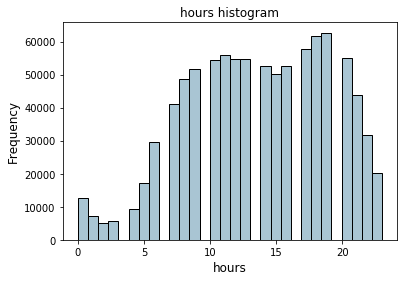

In [25]:
fig, ax = plt.subplots()
ds['hour_ss'].hist(bins=30, color='#A9C5D3'    #ds['hour_ss']>=8)& (ds['hour_ss']<=19)
               , edgecolor='black', grid=False)
ax.set_title('hours histogram', fontsize=12)
ax.set_xlabel('hours', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [ ]:
### This code works to find dates between two dates for each row of a df, but is too slow. 
def dateinterval(dfci, dfco,delta=1):
    for curr, end, i in zip(dfci, dfco, range(len(ds)-1)):   # zip is memory intensive -> in memory...
        aList=[]
        while curr < end:
            yield curr
            aList.append(curr)
            curr += delta
        ds['temp'][i]=aList  
    return ds['temp']

#for result in dateinterval(ds['date_ci'],ds['date_co']):
  #  ds['dateslist_bk']=result

In [26]:
##### create origin - destination categories

ds['user_location_region']=ds['user_location_region'].astype(str)
ds['user_location_city']=ds['user_location_city'].astype(str)

ds['city_state']= ds['user_location_city']+ ', '  + ds['user_location_region']
ds['city_state']= ds['city_state'].astype(str)

ds.loc[ds['hotel_country']=='UNITED STATES OF AMERICA', 'region_dest']='USA'
ds.loc[ds['hotel_country']!='UNITED STATES OF AMERICA', 'region_dest']='ROW'

ds['prop_starrating']=ds['prop_starrating'].astype(int)  

## The below is on hold 
# match: user_location_country, user_location_region, user_location_city,\
# hotel_market (hotel_id?) and orig_destination_distance. ==> find hotel clusters. "leak kagle"

# Data cleaning to do 
# test=ds2[ds2['orig_destination_distance'].isnull()]   NaN
# Latitude - Long NaN


In [27]:
####### create user categories  (business, bleisure, wegetaway, familywkids, familynokids)

ds['user_cat']='' # initialize
ds.loc[(ds['srch_adults_cnt']==1) 
     & (ds['srch_children_cnt']==0) 
     & (ds['is_monfri']==1)   
     & (ds['is_satsun']==0) 
     & (ds['is_satsun_ss']==0)  
     & (ds['is_worktime_ss']==1) 
     & (ds['region_dest']=='USA')
     ,'user_cat']='business_usa'

ds.loc[(ds['srch_adults_cnt']==1) 
     & (ds['srch_children_cnt']==0) 
     & (ds['is_monfri']==1) 
     & (ds['is_satsun']==0) 
     & (ds['is_satsun_ss']==0)
     & (ds['is_worktime_ss']==1) 
     & (ds['region_dest']=='ROW')
     ,'user_cat']='business_row' 

ds.loc[(ds['srch_adults_cnt']==1)     
     & (ds['srch_children_cnt']==0) 
     & (ds['is_monfri']==1) 
     & (ds['is_satsun']==1) 
     & (ds['is_satsun_ss']==0)
     & (ds['is_worktime_ss']==1) 
     & (ds['region_dest']=='USA')
     ,'user_cat']='bleisure_usa'

ds.loc[(ds['srch_adults_cnt']==1)     
     & (ds['srch_children_cnt']==0) 
     & (ds['is_monfri']==1) 
     & (ds['is_satsun']==1) 
     & (ds['is_satsun_ss']==0)
     & (ds['is_worktime_ss']==1) 
     & (ds['region_dest']=='ROW')
     , 'user_cat']='bleisure_row'

ds.loc[(ds['srch_adults_cnt']>=1)     
     & (ds['srch_children_cnt']==0) 
     & (ds['is_monfri']==0) 
     & (ds['is_satsun']==1) 
     & (ds['region_dest']=='USA')
     , 'user_cat']='wegetaway_usa'  

ds.loc[(ds['srch_adults_cnt']>=1)     
     & (ds['srch_children_cnt']==0) 
     & (ds['is_monfri']==0) 
     & (ds['is_satsun']==1) 
     & (ds['region_dest']=='ROW')
     , 'user_cat']='wegetaway_row'

ds.loc[(ds['srch_children_cnt']>0) 
     & (ds['region_dest']=='USA')
     , 'user_cat']='familywkids_usa'  

ds.loc[(ds['srch_children_cnt']>0)  
     & (ds['region_dest']=='ROW')
     , 'user_cat']='familywkids_row' 

ds.loc[(ds['srch_adults_cnt']>1)     
     & (ds['srch_children_cnt']==0) 
     & (ds['region_dest']=='USA')
     , 'user_cat']='familynokids_usa'  

ds.loc[(ds['srch_adults_cnt']>1)     
     & (ds['srch_children_cnt']==0) 
     & (ds['region_dest']=='ROW')
     , 'user_cat']='familynokids_row' 

ds.loc[(ds['srch_adults_cnt']==1)     
     & (ds['srch_children_cnt']==0) 
     & (ds['is_monfri']==1)                                    # diff from wegetaways
     & ((ds['is_worktime_ss']==0) | (ds['is_satsun_ss']==1))   # diff from business
     & (ds['region_dest']=='USA')
     , 'user_cat']='single_usa' 

ds.loc[(ds['srch_adults_cnt']==1)     
     & (ds['srch_children_cnt']==0) 
     & (ds['is_monfri']==1) 
     & ((ds['is_worktime_ss']==0) | (ds['is_satsun_ss']==1)) 
     & (ds['region_dest']=='ROW')
     , 'user_cat']='single_row'     

In [28]:
###### update channel categories

# identify most popular channels. 
tds1=ds.groupby('channel')['channel'].count().rename('channel_freq').reset_index()
tds1.sort_values('channel_freq', ascending=False, inplace=True)
#print(tds1)

# rename channels based on industry knowledge

channels_dic={
            541:'direct',510:'google_srch',231:'tripadvisor?',293:'trivago?',262:'paid_srch',\
            324:'mail',386:'other', 448:'other',355:'other',479:'other',417:'other'
            } # 386 social
#get channel values from channel_dic
ds['channel_cat']=ds['channel'].map(channels_dic)
#ds['channel_cat']

In [29]:
####### create household income and housebold income categories

# import hh income by city and states and merge dataframes
hh_med_inc_state=pd.read_excel('medium_hh_income_state_2015.xlsx', sheet_name=0, header=0)

US_6793_income_cities=pd.read_excel('US_6793_income_cities_2015.xlsx', sheet_name='city_income', header=0)
US_6793_income_cities['city_state']= US_6793_income_cities['city_state'].astype(str)

tds2=pd.merge(ds,hh_med_inc_state,how='left', on='user_location_region')

ds1=pd.merge(tds2,US_6793_income_cities,how='left',on='city_state')
ds1.head(5)

# create one income column
ds1['income_hh']=ds1['city_percapita_inc']

ds1.loc[ds1['city_percapita_inc'].isnull(),
        'income_hh']=ds1['2015_hh_med_inc_state']

# Create bins for income_hh based on US quantile distribution 
bin_ranges_inc = [0, 27000, 56000, 102000, 250000]
bin_names_inc = ['less27K', '27K_56K', '56K_102K', 'more102K']

ds1['income_hh_range'] = pd.cut(np.array(
                           ds1['income_hh']), 
                           bins=bin_ranges_inc)
                    
ds1['income_hh_cat'] = pd.cut(np.array(
                         ds1['income_hh']),
                         bins=bin_ranges_inc,            
                         labels=bin_names_inc)

remove_col = ['city_percapita_inc', 'city_household_inc', 'city_population']
ds1.drop(remove_col, inplace=True, axis=1)
# ds1[ds1['income_hh'].isnull()] # test

In [76]:
###### user_id sessions destination season features

## is_churn / is_prebooking / session_cat (booking is already defined)
# is_churn
tds3=ds1.groupby(['user_id','srch_destination_id'], as_index=False).agg({'is_booking':['sum']})
tds3.columns = ["_".join(x) for x in tds3.columns.ravel()]  # creates 'is_booking_sum'
tds3.rename(columns={'user_id_': 'user_id', 'srch_destination_id_': 'srch_destination_id'}, inplace=True)
tds3.reset_index() 

tds3.loc[tds3['is_booking_sum']==0,'is_churn']=1   # no booking for a user_id destination
tds3.loc[tds3['is_booking_sum']>=1,'is_churn']=0   # some booking(s) for a user_id destination

# join left with ds1 USD_id = user id destination id
ds1 ['USD_id'] = ds1 ['user_id'].astype(str)+ " " + ds1 ['srch_destination_id'].map(str)
tds3['USD_id'] = tds3['user_id'].astype(str)+ " " + tds3['srch_destination_id'].map(str)
remove_col = ['user_id','srch_destination_id','is_booking_sum']
tds3.drop(remove_col, inplace=True, axis=1)
ds1b = pd.merge(ds1,tds3,how='left',on='USD_id')  ### notice the switch from ds1 to ds1b

# is_prebooking 
ds1b['is_session']=1
ds1b['is_prebooking']=ds1b['is_session']-ds1b['is_churn']-ds1b['is_booking']
            
ds1b=ds1b.sort_values('date_ss', kind='mergesort')
        
# session_cat
ds1b['session_cat']=''  # initialize
ds1b.loc[ds1b['is_churn']==1,'session_cat']='churn'
ds1b.loc[ds1b['is_prebooking']==1,'session_cat']='prebooking'
ds1b.loc[ds1b['is_booking']==1,'session_cat']='booking'    


## is_churns / is_prebookings / session_cats   # notice the "s" meaning per season!! 

tds7=ds1b.groupby(['user_id','srch_destination_id','season_cat'], as_index=False).agg({'is_booking':['sum']})
tds7.columns = ["_".join(x) for x in tds7.columns.ravel()]  # creates 'is_booking_sum'
tds7.rename(columns={'user_id_': 'user_id', 'srch_destination_id_': 'srch_destination_id',\
                     'season_cat_':'season_cat'}, inplace=True)
tds7.reset_index() 

tds7.loc[tds7['is_booking_sum']==0,'is_churns']=1   # no booking for a user_id destination season
tds7.loc[tds7['is_booking_sum']>=1,'is_churns']=0   # some booking(s) for a user_id destination season

# join left with ds1b USD_ids = user id destination id combined with season
ds1b ['USD_ids'] = ds1b ['USD_id'].astype(str)+ " " + ds1b ['season_cat'].map(str)
tds7['USD_id'] = tds7['user_id'].astype(str)+ " " + tds7['srch_destination_id'].map(str)
tds7['USD_ids'] = tds7['USD_id'].astype(str)+ " " + tds7['season_cat'].map(str)
remove_col = ['USD_id','user_id', 'srch_destination_id','season_cat','is_booking_sum']
tds7.drop(remove_col, inplace=True, axis=1)
ds1c = pd.merge(ds1b,tds7,how='left',on='USD_ids')

# is_prebookings      
ds1c['is_session']=1
ds1c['is_prebookings']=ds1c['is_session']-ds1c['is_churns']-ds1c['is_booking']    

ds1c=ds1c.sort_values('date_ss', kind='mergesort')

# session category_season
ds1c['session_cats']=''  # initialize
ds1c.loc[ds1c['is_churns']==1,'session_cats']=1
ds1c.loc[ds1c['is_prebookings']==1,'session_cats']=2
ds1c.loc[ds1c['is_booking']==1,'session_cats']=3 

                        
## session rank, destination season session rank, destination timedelta between session

tds4=ds1c[['USD_id', 'season_cat', 'user_id', 'is_session', 'date_ss']]

#ss_rank (session rank per user id per year)
tds4['year_rank_ss'] = tds4.groupby(['user_id'])['is_session'].cumsum()

#dest_ss_rank (session rank per user id per destination)
tds4['season_dest_rank_ss'] = tds4.groupby(['USD_id','season_cat'])['is_session'].cumsum()

#dest_timedelta_ss  (delta between consecutive sessions in days, default 365 days if none before)
tds4['timedelta_ss'] =tds4.groupby(['USD_id'])['date_ss'].diff()
tds4['timedelta_ss']=tds4['timedelta_ss'].fillna(31536000)    # entering default of 365 days
tds4['timedelta_ss']=np.round(tds4['timedelta_ss'] / np.timedelta64(1, "D"),decimals=1)

remove_col = ['USD_id','user_id','is_session','date_ss','season_cat']
tds4.drop(remove_col, inplace=True, axis=1)

ds1d=pd.concat([ds1c, tds4], axis=1)

ds1d.head(3)

,date_time,site_name,user_location_country,user_location_region,user_location_city,user_location_latitude,user_location_longitude,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,hotel_country,is_booking,hotel_id,prop_is_branded,prop_starrating,distance_band,hist_price_band,popularity_band,cnt,date_ss,date_ci,date_co,month_ss,day_ss,hour_ss,month_ci,day_ci,month_co,day_co,date_ss1,month_ci1,month_co1,season_cat,LOS,LOS_range,LOS_cat,is_satsun_ss,is_worktime_ss,is_satsun,is_monfri,BW_ss,BW_ss_range,BW_ss_cat,city_state,region_dest,user_cat,channel_cat,state,2015_hh_med_inc_state,income_hh,income_hh_range,income_hh_cat,USD_id,USD_ids,is_churn,is_session,is_prebooking,session_cat,is_churns,is_prebookings,session_cats,year_rank_ss,season_dest_rank_ss,timedelta_ss
0,2015-01-01 00:03:00,EXPEDIA.COM,UNITED STATES OF AMERICA,OH,WEST CHESTER,39.328640,-84.425730,775.8321,-803007886,0,0,324,2015-01-22,2015-01-23,2,0,1,5527237,UNITED STATES OF AMERICA,0,153390727,1,3,C,H,H,1,2015-01-01 00:03:00,2015-01-22,2015-01-23,1,3,0,1.0,3.0,1.0,4.0,January,January,January,is_winter,1.0,"(0, 1]",0to1day,0,0,0,1,21.0,"(7, 30]",7to30days,"WEST CHESTER, OH",USA,familynokids_usa,mail,Ohio,51610,51610.0,"(27000, 56000]",27K_56K,-803007886 5527237,-803007886 5527237 is_winter,1.0,1,0,churn,1.0,0,1,1,1,365.0
1,2015-01-01 00:03:00,EXPEDIA.COM,UNITED STATES OF AMERICA,CA,SAN JOSE,37.334754,-121.905447,82.2199,-635508862,1,0,510,2015-01-01,2015-01-02,2,0,1,187717089,UNITED STATES OF AMERICA,0,54164532,1,3,F,M,H,1,2015-01-01 00:03:00,2015-01-01,2015-01-02,1,3,0,1.0,3.0,1.0,4.0,January,January,January,is_winter,1.0,"(0, 1]",0to1day,0,0,0,1,-0.0,NaN,0to1day,"SAN JOSE, CA",USA,familynokids_usa,google_srch,California,65087,34977.0,"(27000, 56000]",27K_56K,-635508862 187717089,-635508862 187717089 is_winter,1.0,1,0,churn,1.0,0,1,1,1,365.0
2,2015-01-01 00:05:00,EXPEDIA.COM,UNITED STATES OF AMERICA,VA,RICHMOND,37.555881,-77.498330,2434.4907,1297850351,0,0,510,2015-01-05,2015-01-10,1,0,1,5527578,UNITED STATES OF AMERICA,0,27025644,0,2,C,VL,M,1,2015-01-01 00:05:00,2015-01-05,2015-01-10,1,3,0,1.0,0.0,1.0,5.0,January,January,January,is_winter,5.0,"(4, 375]",over4days,0,0,1,1,4.0,"(1, 7]",1to7days,"RICHMOND, VA",USA,single_usa,google_srch,Virginia,66916,26540.0,"(0, 27000]",less27K,1297850351 5527578,1297850351 5527578 is_winter,0.0,1,1,prebooking,0.0,1,2,1,1,365.0


In [77]:
test=ds1d[['BW_ss','timedelta_ss']]
test.info()

#ds1c['timedelta_ss']=np.round(ds1c['timedelta_ss'] / np.timedelta64(1, "D"),decimals=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936378 entries, 0 to 936377
Data columns (total 2 columns):
BW_ss           936378 non-null float64
timedelta_ss    936378 non-null float64
dtypes: float64(2)
memory usage: 61.4 MB


In [26]:
###### hotel features  (this is a wip) 

# hotel popularity by destination by user_cat 
qt= np.array([0.25, 0.5, 0.75]) 
tds3=ds1b.groupby(['srch_destination_id','user_cat','hotel_id'], as_index=True).is_booking.sum()
tds2.columns = ["_".join(x) for x in tds2.columns.ravel()]  # creates 'is_booking_sum'
tds2.rename(columns={'user_id_': 'user_id', 'srch_destination_id_': 'srch_destination_id'}, inplace=True)
tds2.reset_index() 

#tds4.quantile(qt,axis = 1)
#.sort(Ascending=False)



,srch_destination_id,user_cat,hotel_id,is_booking
0,8369,bleisure_usa,164392,1
1,8369,bleisure_usa,867069,0
2,8369,bleisure_usa,1252244,1
3,8369,bleisure_usa,28108877,0
4,8369,bleisure_usa,57603579,0
5,8369,bleisure_usa,59739076,0
6,8369,bleisure_usa,79393200,0
7,8369,business_usa,57070,1
8,8369,business_usa,224935,0
9,8369,business_usa,586395,0


In [78]:
###### interaction features 

def inter_feature(df, dfcolname1, dfcolname2):
    input  = df[[dfcolname1, dfcolname2]].values
    output = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit_transform(input)
    return output[:,2];

ds1d['package_income_t'] = inter_feature(ds1d,'is_package','income_hh')
ds1d['mobile_BW_t']      = inter_feature(ds1d,'is_mobile','BW_ss')  


    cluster_id  cluster_count  cluster
0            1            351  VL L VC
80          81            485  VH L VC
84          85            531  VH L VF
20          21            620   L L VC
60          61            673   H L VC


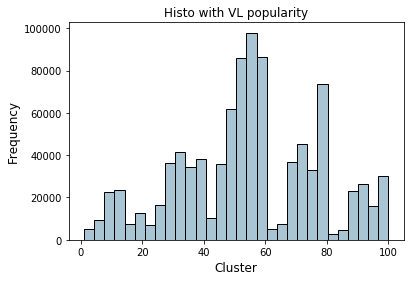

In [79]:
##### hotel cluster = combination of hotel bands  (for target variable ML2)

# define a dictionary hotel_band
def create_dict(price_band, popularity_band, distance_band, len_dict):
    keys = [' '.join(p) for p in itertools.product(price_band, popularity_band, distance_band)]
    values=list(range(1,len_dict+1,1)) 
    return dict(zip(keys, values)) 
    
list_price_band=['VL','L','M','H','VH'] 
list_popularity_band=['L','M','H','VH']  # merged VL and L (too few VL)
list_distance_band=['VC','C','M','F','VF']

hotel_band_dict = create_dict(list_price_band,list_popularity_band,list_distance_band,100)
inv_hotel_band_dict = {v: k for k, v in hotel_band_dict.items()}  # inverse

# create cluster_id in df - merge VL and L for popularity
ds1d.loc[ds1d['popularity_band']=='VL','popularity_band'] = 'L'
ds1d['hotel_band']=ds1d['hist_price_band'] + ' ' + ds1d['popularity_band'] + ' ' + ds1d['distance_band']

# map with dictionary
ds1d['cluster_id']= ds1d['hotel_band'].map(hotel_band_dict)

# verify the distribution of clusters: 
fig, ax = plt.subplots()
ds1d.loc[ds1d['is_session'] == 1,'cluster_id'].hist(bins=30, color='#A9C5D3'
                           , edgecolor='black', grid=False)
ax.set_title('Histo with VL popularity', fontsize=12)
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Show least popular clusters 
tds6_cluster=ds1d.groupby('cluster_id')['cluster_id'].count().rename('cluster_count').reset_index()
tds6_cluster=tds6_cluster.sort_values('cluster_count')
tds6_cluster['cluster']= tds6_cluster['cluster_id'].map(inv_hotel_band_dict)
print(tds6_cluster[:5])

### 3 save file 

In [80]:
# Save ds as a file 

file_to_save = 'ds1copy.csv'
if not os.path.exists(file_to_save):
    ds1d.to_csv(file_to_save,sep = "|",index=False, chunksize=100)
        
else:
    file_to_save = 'ds1.csv'
    ds1d.to_csv(file_to_save,sep = "|",index=False, chunksize=100)

###  appendix

Text(0,0.5,'Frequency')

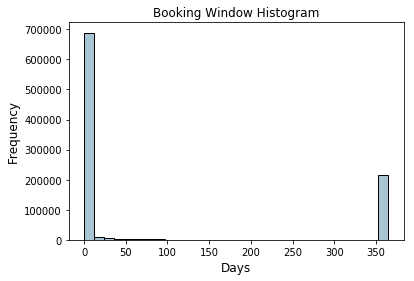

In [43]:
fig, ax = plt.subplots()
ds1d['timedelta_ss'].hist(bins=30, color='#A9C5D3'
                           , edgecolor='black', grid=False)
ax.set_title('Booking Window Histogram', fontsize=12)
ax.set_xlabel('Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [61]:
### this is a test regarding numpy slicing.

import numpy as np
arr = np.array([[1, 2], [3, 4]])  
print(arr.mean(1)) # compute the mean of array arr along the axis 1, put the result in one row
arr=arr.mean(1)[(slice(None), None)] #puts the result into two rows
print(arr)

arr -= arr.mean(1)[(slice(None), None)]
arr

  

[1.5 3.5]
[[1.5]
 [3.5]]


array([[0.],
       [0.]])

In [120]:
# this is a test
dftest = pd.DataFrame({'pets':['cat', 'dog', 'cat', 'monkey', 'dog', 'dog'],\
                       'owner':['Champ', 'Ron', 'Brick', 'Champ', 'Veronica', 'Ron'],\
                       'location':['San_Diego', 'New_York', 'New_York', 'San_Diego', 'San_Diego', 'New_York']
                      })
dftest

,pets,owner,location
0,cat,Champ,San_Diego
1,dog,Ron,New_York
2,cat,Brick,New_York
3,monkey,Champ,San_Diego
4,dog,Veronica,San_Diego
5,dog,Ron,New_York


In [122]:
dftest6= pd.get_dummies(dftest, columns=['pets', 'owner'], drop_first=True)
dftest6

,location,pets_dog,pets_monkey,owner_Champ,owner_Ron,owner_Veronica
0,San_Diego,0,0,1,0,0
1,New_York,1,0,0,1,0
2,New_York,0,0,0,0,0
3,San_Diego,0,1,1,0,0
4,San_Diego,1,0,0,0,1
5,New_York,1,0,0,1,0


In [110]:
dftest1=dftest.apply(LabelEncoder().fit_transform)

'''
d = defaultdict(LabelEncoder)

# Encoding the variable
fit = df.apply(lambda x: d[x.name].fit_transform(x))

# Inverse the encoded
fit.apply(lambda x: d[x.name].inverse_transform(x))

# Using the dictionary to label future data
df.apply(lambda x: d[x.name].transform(x))
'''
dftest1

,pets,owner,location
0,0,1,1
1,1,2,0
2,0,0,0
3,2,1,1
4,1,3,1
5,1,2,0


In [116]:
dftest2=dftest1.apply(LabelEncoder().fit_transform)
dftest2

,pets,owner,location
0,0,1,1
1,1,2,0
2,0,0,0
3,2,1,1
4,1,3,1
5,1,2,0


In [113]:
#dftest1=dftest.apply(LabelEncoder().fit_transform)

d = defaultdict(LabelEncoder)

# Encoding the variable
fit = dftest.apply(lambda x: d[x.name].fit_transform(x))

'''
# Inverse the encoded
fit.apply(lambda x: d[x.name].inverse_transform(x))

# Using the dictionary to label future data  # aka, in my understanding: test.
df.apply(lambda x: d[x.name].transform(x))
dftest1
'''
fit

,pets,owner,location
0,0,1,1
1,1,2,0
2,0,0,0
3,2,1,1
4,1,3,1
5,1,2,0


In [ ]:
dftest5=dftest1.apply(LabelEncoder().fit_transform)
dftest2

In [115]:
# Inverse the encoded
inverse=fit.apply(lambda x: d[x.name].inverse_transform(x))
inverse

,pets,owner,location
0,cat,Champ,San_Diego
1,dog,Ron,New_York
2,cat,Brick,New_York
3,monkey,Champ,San_Diego
4,dog,Veronica,San_Diego
5,dog,Ron,New_York


In [31]:
# hotel popularity by destination by user_cat 
qt= np.array([0.25, 0.5, 0.75]) 
tds4=ds1b.groupby(['srch_destination_id','user_cat','hotel_id'], as_index=True).is_booking.sum()
tds4.head(10)#tds5=tds4.quantile(qt)
#tds5

srch_destination_id  user_cat      hotel_id
8369                 bleisure_usa  164392      1
                                   867069      0
                                   1252244     1
                                   28108877    0
                                   57603579    0
                                   59739076    0
                                   79393200    0
                     business_usa  57070       1
                                   224935      0
                                   586395      0
Name: is_booking, dtype: int64

In [ ]:
'''
.agg({'hotel_id':['count']})

tds2=ds1.groupby(['user_id','srch_destination_id'], as_index=False).agg({'is_booking':['sum']})
tds2.columns = ["_".join(x) for x in tds2.columns.ravel()]  # creates 'is_booking_sum'
tds2.rename(columns={'user_id_': 'user_id', 'srch_destination_id_': 'srch_destination_id'}, inplace=True)
tds2.reset_index() 

'''

In [181]:
test1=ds1.groupby(['user_id', 'date_ci', 'date_co'], as_index=False).is_booking.sum()
test2=test1[test1['is_booking']==0]
test3=test1[test1['is_booking']>=1]
print(test2)
print(test3)

           user_id    date_ci    date_co  is_booking
1      -2147376863 2015-06-14 2015-06-15           0
5      -2147101798 2015-01-15 2015-01-16           0
6      -2147072139 2015-03-29 2015-04-01           0
7      -2147072139 2015-05-28 2015-05-29           0
9      -2147070148 2015-01-24 2015-01-25           0
11     -2146977961 2015-02-24 2015-02-25           0
12     -2146977961 2015-02-24 2015-03-02           0
18     -2146181098 2015-12-01 2015-12-04           0
19     -2145964935 2015-09-07 2015-09-14           0
20     -2145964935 2015-09-14 2015-09-15           0
22     -2145964935 2015-10-18 2015-10-19           0
25     -2145960898 2016-01-17 2016-01-23           0
26     -2145725498 2015-03-15 2015-03-20           0
27     -2145689233 2015-03-22 2015-03-25           0
29     -2145689233 2015-08-29 2015-08-30           0
34     -2145689233 2015-12-28 2015-12-31           0
36     -2145313748 2016-01-04 2016-01-07           0
38     -2145073870 2016-01-01 2016-01-02      

In [153]:
tds3=ds1.groupby(['user_id','srch_destination_id','date_ss'], as_index=True).is_booking.sum()

#.remame(columns={'sum':'is_booking_sum'})
#index.rename('user_id_date_ss', inplace=True)
tds3.head(20)

user_id      srch_destination_id  date_ss            
-2147411492  188617112            2015-05-29 13:48:00    0
                                  2015-05-29 13:51:00    1
-2147376863  187807392            2015-06-12 16:10:00    0
                                  2015-06-12 16:12:00    0
                                  2015-06-14 11:58:00    0
                                  2015-06-14 12:03:00    1
             187823853            2015-06-11 07:00:00    0
-2147349150  5526679              2015-05-22 13:27:00    0
                                  2015-05-22 13:30:00    1
-2147167332  24802324             2015-09-23 20:22:00    0
                                  2015-09-23 20:25:00    0
                                  2015-09-23 20:35:00    0
                                  2015-09-23 20:39:00    1
-2147101798  186071826            2015-01-04 07:27:00    0
-2147072139  5526989              2015-04-23 20:57:00    0
                                  2015-05-12 09:59:00    0
  

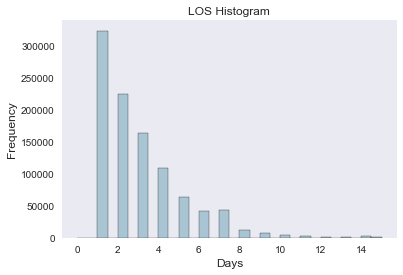

In [250]:
fig, ax = plt.subplots()
ds.loc[(ds['LOS']>=0) & (ds['LOS']<=15),'LOS'].hist(bins=30, color='#A9C5D3'    
               , edgecolor='black', grid=False)
ax.set_title('LOS Histogram', fontsize=12)
ax.set_xlabel('Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [254]:
quantile_list = [0, .25, .5, .75, 1.]
quantiles = ds['LOS'].quantile(quantile_list)
quantiles

0.00   -363.0
0.25      1.0
0.50      2.0
0.75      4.0
1.00    375.0
Name: LOS, dtype: float64

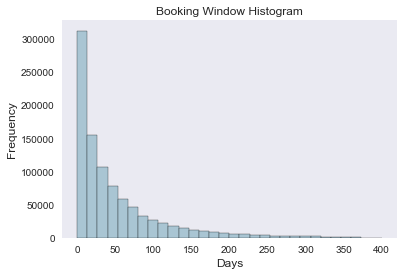

In [253]:
fig, ax = plt.subplots()
ds.loc[(ds['BW_ss']>=0) & (ds['BW_ss']<=400),'BW_ss'].hist(bins=30, color='#A9C5D3'
                           , edgecolor='black', grid=False)
ax.set_title('Booking Window Histogram', fontsize=12)
ax.set_xlabel('Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [201]:
quantile_list = [0, .25, .5, .75, 1.]
quantiles = ds['BW_ss'].quantile(quantile_list)
quantiles

0.00   -312.604167
0.25      6.307639
0.50     24.572222
0.75     63.468750
1.00    559.095139
Name: BW_ss, dtype: float64

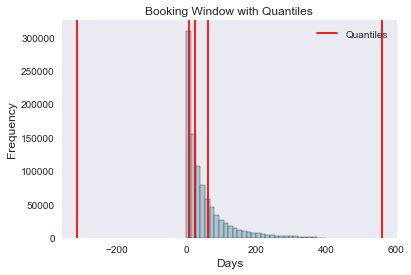

In [248]:
fig, ax = plt.subplots()
ds.loc[(ds['BW_ss']>=0) & (ds['BW_ss']<=400),'BW_ss'].hist(bins=30, color='#A9C5D3'
                           , edgecolor='black', grid=False)

for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)

ax.set_title('Booking Window with Quantiles', 
             fontsize=12)
ax.set_xlabel('Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [ ]:
def print_values(**kwargs):
    for key, value in kwargs.items():
        print("The value of {} is {}".format(key, value))

print_values(
            name_1="Alex",
            name_2="Gray",
            name_3="Harper",
            name_4="Phoenix",
            name_5="Remy",
            name_6="Val"

In [ ]:
for y in agg.columns:
    if(agg[y].dtype == np.float64 or agg[y].dtype == np.int64):
          treat_numeric(agg[y])
    else:
          treat_str(agg[y])